In [1]:
import numpy as np
import pandas as pd

In [2]:
LLM='llama3-70B'
POLYTER_TYPE='OMIEC_NEUROMORPHIC'
DATE='030924'

In [3]:
response = pd.read_excel('../../dataframes/llama3-70B-OMIEC_NEUROMORPHIC030924_0.2_temp_dict2_RESPONSES.xlsx')
raw_data =  pd.read_excel('../../data/raw/OMIEC_NEUROMORPHIC_20_08_24_v2.xlsx')

In [4]:
nan_count = response.isna().sum()
print(nan_count)

index        0
response    11
dtype: int64


In [5]:
result = pd.concat([response, raw_data], axis=1)
result.drop('index', axis=1, inplace=True)

In [6]:
response = response.dropna()
responses_cleaned = response[response['response'] != '{}']
responses_cleaned = responses_cleaned[responses_cleaned['response'] != 'None']

In [7]:
import re
import json

def prepare_dict(df):
    
    all_dicts = []
    index_nones = []
    for index, row in df.iterrows():
        try:
            if "PEDOT: PSS" in row['response']:
               row['response'] = row['response'].replace("PEDOT: PSS", "PEDOT:PSS")
            
            if "'Doped?:' " in row['response']:
                dicts = row['response'].strip().replace("'Doped?:'", "'Doped?':").rstrip(';').split(';')
            else:
                dicts = row['response'].strip().rstrip(';').split(';')
                
            dicts = [d.strip().replace("'", '"') for d in dicts]
            json_data = f"[{','.join(dicts)}]"
            dictt = json.loads(json_data)
        except Exception as e:
            print(index, '\n', row['response'], '\n')
            #print(row['response'].replace("'Doped?:'", "'Doped?':"))
            
        for polymer in dictt:
            #polymer['Index'] = index 
            if "Doped?:" in polymer:
                polymer["Doped?"] = polymer.pop("Doped?:")

            if 'Polymer Chemical Abbreviation' not in polymer:
                key = list(polymer.keys())[0]
                polymer['Polymer Chemical Abbreviation'] = polymer[key]
                
            if 'Polymer Mentioned Name' not in polymer:
                polymer['Polymer Mentioned Name'] = list(polymer.keys())[0]
                
            new_dict = {index: polymer}
            
            all_dicts.append(new_dict)
    
    return all_dicts, index_nones



In [8]:

polymer_dicts, _ = prepare_dict(responses_cleaned)

polymers = []

for polymer in polymer_dicts:
    print(polymer[list(polymer.keys())[0]])
    polymers.append(polymer[list(polymer.keys())[0]]['Polymer Chemical Abbreviation'])


{'Polymer Mentioned Name': 'polythiophene', 'Polymer Chemical Abbreviation': 'PTh', 'Polymer Application': 'neuromorphic computing, healthcare, bioelectronic devices', 'Doped?': 'p-doped'}
{'Polymer Mentioned Name': 'naphthalene diimide-based polymer', 'Polymer Chemical Abbreviation': 'NDI', 'Polymer Application': 'neuromorphic computing, healthcare, bioelectronic devices', 'Doped?': 'n-doped'}
{'Polymer Mentioned Name': 'melanin', 'Polymer Chemical Abbreviation': 'Mel', 'Polymer Application': 'bioelectronics, neuromorphic computing, soft robotics, energy storage, organic electrochemical transistors, supercapacitors', 'Doped?': 'not doped'}
{'Polymer Mentioned Name': 'poly(3,4-ethylenedioxythiophene) polystyrene sulfonate', 'Polymer Chemical Abbreviation': 'PEDOT:PSS', 'Polymer Application': 'organic electrochemical transistors, supercapacitors', 'Doped?': 'not doped'}
{'Polymer Mentioned Name': 'poly(3-[2-[2-(2-methoxyethoxy)ethoxy]ethyl]thiophene -2,5-diyl)', 'Polymer Chemical Abbrev

In [9]:
# Função para encontrar a interseção entre dois conjuntos de polímeros
def verificar_interseccao(p1, p2):
    conjunto1 = {p1['Polymer Chemical Abbreviation'].replace('/', '-').replace(':', '-').lower(),
                 p1['Polymer Mentioned Name'].replace('/', '-').replace(':', '-').lower()}
    conjunto2 = {p2['Polymer Chemical Abbreviation'].replace('/', '-').replace(':', '-').lower(),
                 p2['Polymer Mentioned Name'].replace('/', '-').replace(':', '-').lower()}
    return not conjunto1.isdisjoint(conjunto2)

# Agrupar polímeros com base na interseção
def agrupar_polimeros(polimeros):
    grupos = []
    visitados = set()
    
    for i, dados1 in enumerate(polimeros):
        
        if i in visitados:
            continue
        
        grupo_atual = set()
        grupo_nome_atual = []
        
        # Adicionar o polímero atual ao grupo
        grupo_atual.add(i)
        grupo_nome_atual.append([dados1[list(dados1.keys())[0]]['Polymer Chemical Abbreviation'], list(dados1.keys())[0]])
        visitados.add(i)
        
        # Comparar com elementos subsequentes
        for j in range(i + 1, len(polimeros)):
            dados2 = polimeros[j]
            if verificar_interseccao(dados1[list(dados1.keys())[0]], dados2[list(dados2.keys())[0]]):
                grupo_atual.add(j)
                grupo_nome_atual.append([dados2[list(dados2.keys())[0]]['Polymer Chemical Abbreviation'], list(dados2.keys())[0]])
                visitados.add(j)
        
        grupos.append(grupo_nome_atual)
    
    return grupos


grupos_nomes_encontrados = agrupar_polimeros(polymer_dicts)
#grupos_nomes_encontrados = sorted(grupos_nomes_encontrados, key=len, reverse=True)
grupos_nomes = [list(map(list, set(map(tuple, grupo)))) for _, grupo in enumerate(grupos_nomes_encontrados, start=1)]
grupos_nomes = sorted(grupos_nomes, key=len, reverse=True)
soma = 0

for i, grupo in enumerate(grupos_nomes, start=1):
    soma += len(grupo)
    #print(f"{grupo[0][0]}: {len(grupo)}")
print(f"Quantidade polímeros: {soma} | Quantidade polímeros únicos: {len(grupos_nomes)}")


Quantidade polímeros: 86 | Quantidade polímeros únicos: 51


In [10]:
items_to_remove = [r'(?i)\bmixed\b',
                   r'(?i)\bnone\b',
                   r'MIEC.*',
                   'based', 
                   r'[Pp]olymer',
                   r'OECT.*',
                   'conjug',
                   r'^$', 
                   r'^PSS$'
                   ]


In [11]:

print("Polímeros identificados antes:", len(grupos_nomes))
for item in items_to_remove:
    for p in grupos_nomes:
        pattern = re.compile(item)
        if pattern.search(p[0][0]):
            #print(item, '\n', p)
            grupos_nomes.remove(p)

print("Polímeros identificados após remoção:",len(grupos_nomes))

Polímeros identificados antes: 51
Polímeros identificados após remoção: 49


In [12]:
df = []
for i,grupo in enumerate(grupos_nomes, start=1):
    linha_df = {'Nome': grupo[0][0], 'Quantidade_Encontrada': len(grupo), 'Identificação_Encontrados': grupo}
    df.append(linha_df)
polímeros_estruturados = pd.DataFrame(df)
polímeros_estruturados

,Nome,Quantidade_Encontrada,Identificação_Encontrados
0,PEDOT:PSS,17,"[[PEDOT:PSS, 80], [PEDOT:PSS, 109], [PEDOT:PSS..."
1,P3HT,6,"[[P3HT, 22], [P3HT, 121], [P3HT, 66], [P3HT, 4..."
2,PEDOT,5,"[[PEDOT, 41], [PEDOT, 44], [PEDOT, 75], [PEDOT..."
3,PTh,2,"[[PTh, 33], [PTh, 0]]"
4,BBL,2,"[[BBL, 12], [BBL, 102]]"
5,p(g2T-TT),2,"[[p(g2T-TT), 40], [p(g2T-TT), 41]]"
6,PPY,2,"[[PPY, 45], [PPy, 68]]"
7,p(g2T-T),2,"[[p(g2T-T), 50], [p(g2T-T), 57]]"
8,PCPDTBT-SO3K,2,"[[PCPDTBT-SO3K, 83], [CPE-K, 107]]"
9,PSSNa,2,"[[PSSNa, 85], [PSSNa, 109]]"


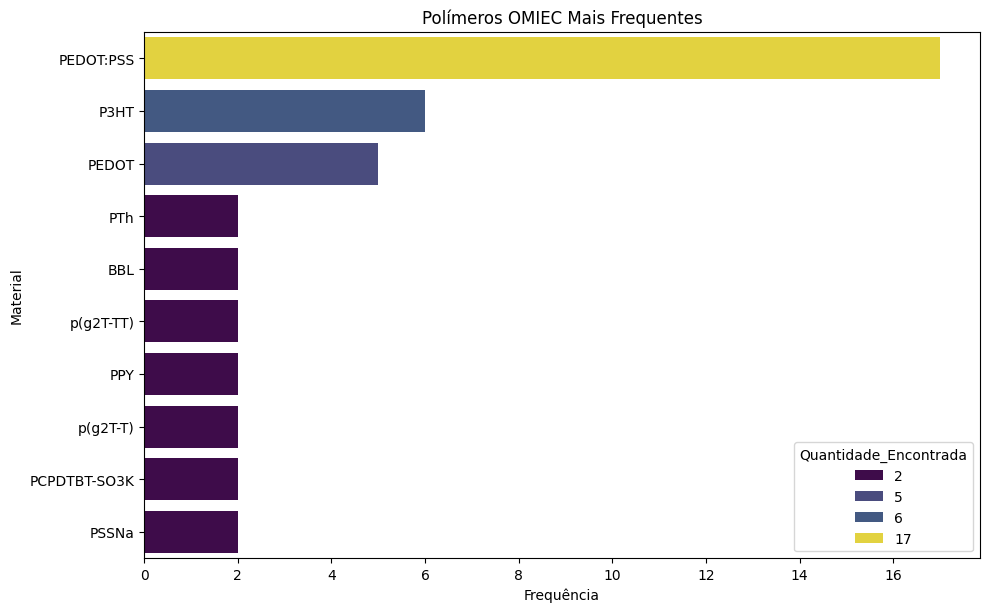

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))


sns.barplot(x=polímeros_estruturados[:10]['Quantidade_Encontrada'], y=polímeros_estruturados[:10]['Nome'], hue=polímeros_estruturados[:10]['Quantidade_Encontrada'],palette="viridis")
plt.xlabel('Frequência')
plt.ylabel('Material')

# Ajustando layout para não cortar legendas
plt.tight_layout()
plt.title('Polímeros OMIEC Mais Frequentes')
# Salvando a imagem
plt.savefig(f'images/{LLM}-{POLYTER_TYPE}{DATE}_RESPONSES_ranking.png')

# Exibindo a imagem
plt.show()


Tendência de publicações sobre a temática durante os anos

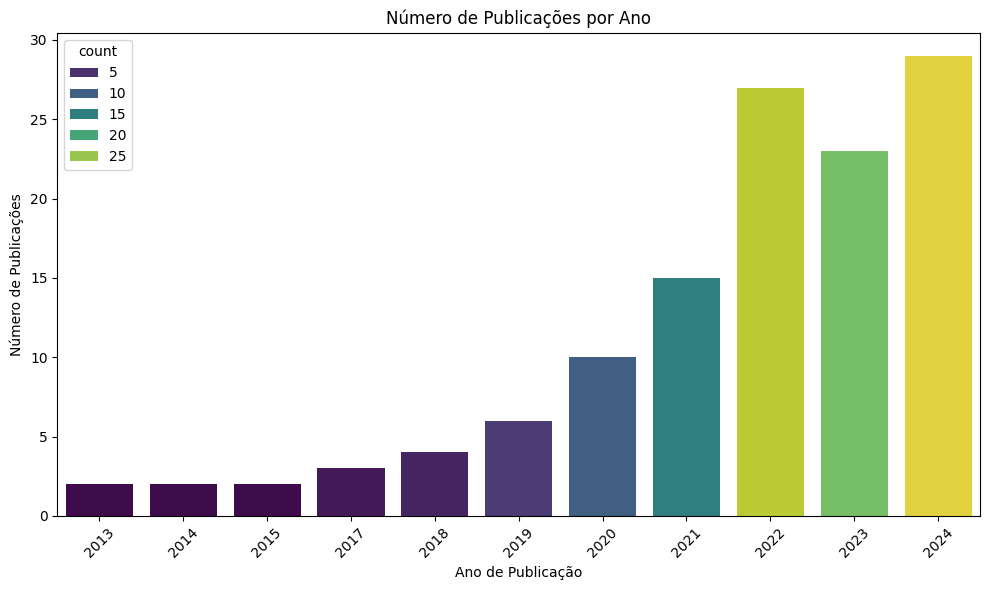

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Supondo que 'raw_data' seja o seu DataFrame e 'Publication Year' seja a coluna com os anos de publicação
publication_counts = raw_data['Publication Year'].value_counts()

# Ordenar os valores pela data para melhorar a visualização (opcional)
publication_counts = publication_counts.sort_index()

# Criar o gráfico de barras com Seaborn usando a paleta "viridis"
plt.figure(figsize=(10, 6))
sns.barplot(
    x=publication_counts.index, 
    y=publication_counts.values,
    hue=publication_counts, 
    palette="viridis"  # Aplica a paleta de cores "viridis"
)

# Configurar o título e os rótulos dos eixos
plt.title('Número de Publicações por Ano')
plt.xlabel('Ano de Publicação')
plt.ylabel('Número de Publicações')

# Mostrar o gráfico
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo x para melhor visualização

# Ajustando layout para não cortar legendas
plt.tight_layout()

# Salvando a imagem
plt.savefig(f'images/{LLM}-{POLYTER_TYPE}{DATE}_publicação_por_ano.png')

plt.show()


### Localizando os artigos em que aparecem os polímeros

In [15]:
busca = 'BBL'

resultado = polímeros_estruturados.loc[polímeros_estruturados['Nome'] == busca]
for ID in list(resultado['Identificação_Encontrados'])[0]:
    print(busca,"| Citações:", raw_data.loc[ID[1]]['Times Cited, All Databases'] , '\n', raw_data.loc[ID[1]]['Abstract'], '\n')

BBL | Citações: 13 
 Organic electrochemical transistors (OECTs) are a rapidly advancing technology that plays a crucial role in the development of next-generation bioelectronic devices. Recent advances in p-type/n-type organic mixed ionic-electronic conductors (OMIECs) have enabled power-efficient complementary OECT technologies for various applications, such as chemical/biological sensing, large-scale logic gates, and neuromorphic computing. However, ensuring long-term operational stability remains a significant challenge that hinders their widespread adoption. While p-type OMIECs are generally more stable than n-type OMIECs, they still face limitations, especially during prolonged operations. Here, we demonstrate that simple methylation of the pyrrole-benzothiazine-based (PBBT) ladder polymer backbone results in stable and high-performance p-type OECTs. The methylated PBBT (PBBT-Me) exhibits a 25-fold increase in OECT mobility and an impressive 36-fold increase in & mu;C* (mobility 

### Frequência de publicação para TOP5 polímeros

In [16]:
dfs = []

for polymer in polímeros_estruturados[:5]['Nome']:
    resultado = polímeros_estruturados.loc[polímeros_estruturados['Nome'] == polymer]
    lista_ids = [ID[1] for ID in list(resultado['Identificação_Encontrados'])[0]]
    publication_counts = raw_data.iloc[lista_ids]['Publication Year'].value_counts()
    publication_counts = publication_counts.sort_index().reset_index()
    publication_counts.columns = ['Year', 'Count']
    publication_counts['Polymer'] = polymer
    dfs.append(publication_counts)

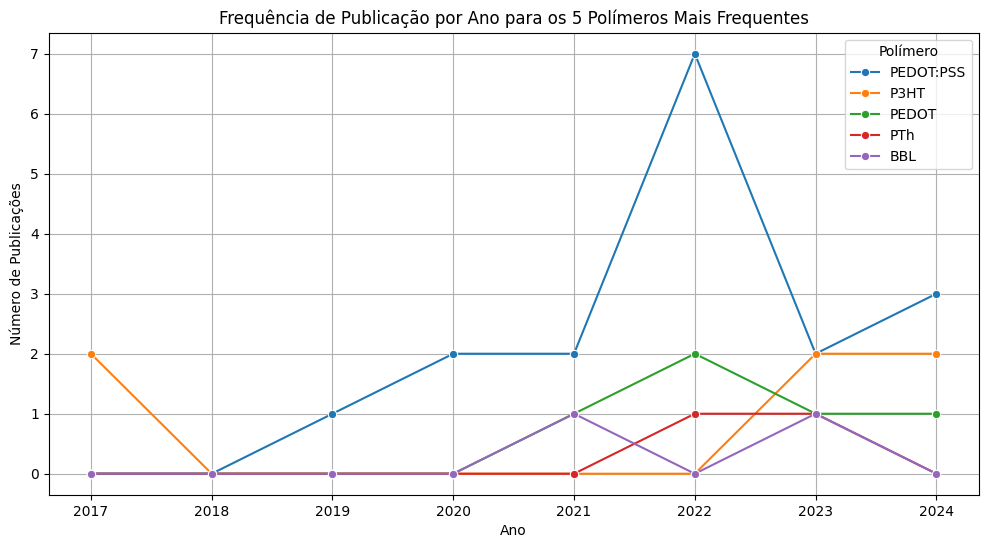

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

dfs = []

for polymer in polímeros_estruturados[:5]['Nome']:
    resultado = polímeros_estruturados.loc[polímeros_estruturados['Nome'] == polymer]
    lista_ids = [ID[1] for ID in list(resultado['Identificação_Encontrados'])[0]]
    publication_counts = raw_data.iloc[lista_ids]['Publication Year'].value_counts()
    publication_counts = publication_counts.sort_index().reset_index()
    publication_counts.columns = ['Year', 'Count']
    publication_counts['Polymer'] = polymer
    dfs.append(publication_counts)
    
combined_df = pd.concat(dfs)

# Definir o intervalo de anos que você deseja garantir
anos_desejados = range(combined_df['Year'].min(), combined_df['Year'].max() + 1)

# Criar um DataFrame de referência com todos os anos para cada polímero
reference_df = pd.DataFrame([(polymer, year) for polymer in combined_df['Polymer'].unique() for year in anos_desejados], columns=['Polymer', 'Year'])

# Mesclar com o DataFrame combinado para garantir que todos os anos estejam presentes
combined_df = pd.merge(reference_df, combined_df, on=['Polymer', 'Year'], how='left').fillna(0)

# Plotar os dados
plt.figure(figsize=(12, 6))
sns.lineplot(data=combined_df, x='Year', y='Count', hue='Polymer', marker='o')
plt.title('Frequência de Publicação por Ano para os 5 Polímeros Mais Frequentes')
plt.xlabel('Ano')
plt.ylabel('Número de Publicações')
plt.legend(title='Polímero')
plt.grid(True)

#plt.xlim(left=2010)

plt.savefig(f'images/{LLM}-{POLYTER_TYPE}{DATE}_freq_publicação_polimero.png')

plt.show()


### Demais análises

In [18]:
aplicações = []
for i in polymer_dicts:
    app = i[list(i.keys())[0]]['Polymer Application'].split(',')
    aplicações.extend(app)
    '''for f in app:
        if 'intermediate temperature solid oxide fuel cells' in f.lower():
            print(i, '\n')
            print(raw_data.loc[list(i.keys())[0]]['Abstract'], '\n')'''
print(len(aplicações))

230


In [19]:
aplicações = pd.Series([a.lower().strip() for a in aplicações ])

In [20]:
len(np.unique(aplicações))

81

In [21]:
replacements = {
    r"\borganic(?:\s+electrochemical(?:\s+transistors?)?)?\b|\belectrochemical\s+transistors?\b": 'oect',
    r"\b(oect|oects)\b(?:\s*.*)?[\)\']?" : 'oect'
}

for pattern, replacement in replacements.items():
    aplicações = aplicações.str.replace(pattern, replacement, regex=True, case=False)

In [22]:
len(np.unique(aplicações))

75

In [23]:
aplicações.value_counts().head(20)

oect                             41
neuromorphic                     36
bioelectronics                   24
neuromorphic computing           21
biosensors                        7
neuromorphic devices              6
synaptic                          5
bioelectronic                     3
drug delivery systems             3
biological interfacing            3
brain-inspired computing          3
biosensing systems                3
artificial synapse                2
supercapacitors                   2
healthcare                        2
soft robotics                     2
wearable                          2
bioelectronic devices             2
energy conversion and storage     2
neural recordings                 2
Name: count, dtype: int64

Verificando que foi extraído sobre dopagem

In [24]:
dopado = []
for i in polymer_dicts:
    dop = i[list(i.keys())[0]]['Doped?'].split(',')
    dopado.extend(dop)
    '''for f in app:
        if 'intermediate temperature solid oxide fuel cells' in f.lower():
            print(i, '\n')
            print(raw_data.loc[list(i.keys())[0]]['Abstract'], '\n')'''
print(len(dopado))

86


In [25]:
dopado = pd.Series([d.lower().strip().replace('-', ' ').replace('_', ' ').replace('type', 'doped') for d in dopado ])

In [26]:
items_to_remove = [ r'^$', 
                   r'(?i)\bnone\b'
                   ]

    
for item in items_to_remove:
    dopado = dopado[~dopado.str.contains(item, regex=True)]

In [27]:
len(np.unique(dopado))

3

In [28]:
dopado.value_counts().head(20)

not doped    64
p doped      14
n doped       8
Name: count, dtype: int64

### Playground

In [29]:
import plotly.express as px

# Supondo que 'raw_data' seja o seu DataFrame e 'Publication Year' seja a coluna com os anos de publicação
publication_counts = raw_data['Publication Year'].value_counts()

# Ordenar os valores pela data para melhorar a visualização (opcional)
publication_counts = publication_counts.sort_index()

# Criar o gráfico de barras com Plotly
fig = px.bar(
    x=publication_counts.index, 
    y=publication_counts.values, 
    labels={'x': 'Publication Year', 'y': 'Number of Publications'},
    title='Number of Publications per Year',
    color=publication_counts.index,  # Adiciona cor baseado no índice (ano de publicação)
    color_continuous_scale='viridis'  # Aplica a paleta "viridis"
)

# Configurar o layout
fig.update_layout(
    xaxis=dict(tickangle=45),  # Rotaciona os rótulos do eixo x para melhor visualização
    yaxis_title='Number of Publications',
    xaxis_title='Publication Year',
    coloraxis_showscale=False  # Oculta a barra de escala de cores, se indesejado
)

# Mostrar o gráfico
fig.show()
